In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
%matplotlib inline
def argmax(x):
    return np.argmax(np.array(x))
def get_max(data, i):
    data.loc[i, "smooth_or_featured"] = argmax([data.iloc[i, 1], data.iloc[i, 2], data.iloc[i, 3]])
    data.loc[i, "disk_edge_on"] = argmax([data.iloc[i, 4], data.iloc[i, 5]])
    data.loc[i, "has_spiral_arms"] = argmax([data.iloc[i, 6], data.iloc[i, 7]])

    data.loc[i, "bar"] = argmax([data.iloc[i, 8], data.iloc[i, 9], data.iloc[i, 10]])
    data.loc[i, "bulge_size"] = argmax([data.iloc[i, 11], data.iloc[i, 12], data.iloc[i, 13], data.iloc[i, 14], data.iloc[i, 15]])
    data.loc[i, "how_rounded"] = argmax([data.iloc[i, 16], data.iloc[i, 17], data.iloc[i, 18]])
    data.loc[i, "edge_on_bulge"] = argmax([data.iloc[i, 19], data.iloc[i, 20], data.iloc[i, 21]])
    data.loc[i, "spiral_winding"] = argmax([data.iloc[i, 22], data.iloc[i, 23], data.iloc[i, 24]])
    data.loc[i, "spiral_arm_count"] = argmax([data.iloc[i, 25], data.iloc[i, 26], data.iloc[i, 27], data.iloc[i, 28], data.iloc[i, 29], data.iloc[i, 30]])
    data.loc[i, "merging"] = argmax([data.iloc[i, 31], data.iloc[i, 32], data.iloc[i, 33], data.iloc[i, 34]])
def get_label(data):
    pred_mw = 7
    if data[31] > data[32] and data[31] > data[33] and data[31] > data[34]:
        if data[1] > data[2] and data[1] > data[3]:
            if data[16] > data[17] and data[16] > data[18]:
                pred_mw = 1
            elif data[17] > data[16] and data[17] > data[18]:
                pred_mw = 2
            elif data[18] > data[16] and data[18] > data[17]:
                pred_mw = 3
        elif data[2] > data[1] and data[2] > data[3]:
            if data[4] > data[5]:
                pred_mw = 4
            elif data[5] > data[4]:
                if data[8] > data[10]:
                    pred_mw = 6
                elif data[10] > data[8]:
                    pred_mw = 5
    else:
        pred_mw = 0
    return pred_mw
def get_c_max(data, i):
    data.loc[i, "smooth_or_featured_c"] = argmax([data.loc[i, "smooth_or_featured_smooth_fraction"], data.loc[i, "smooth_or_featured_featured_or_disk_fraction"], data.loc[i, "smooth_or_featured_artifact_fraction"]])
    data.loc[i, "disk_edge_on_c"] = argmax([data.loc[i, "disk_edge_on_yes_fraction"], data.loc[i, "disk_edge_on_no_fraction"]])
    data.loc[i, "has_spiral_arms_c"] = argmax([data.loc[i, "has_spiral_arms_yes_fraction"], data.loc[i, "has_spiral_arms_no_fraction"]])
    data.loc[i, "bar_c"] = argmax([data.loc[i, "bar_strong_fraction"], data.loc[i, "bar_weak_fraction"], data.loc[i, "bar_no_fraction"]])
    data.loc[i, "bulge_size_c"] = argmax([data.loc[i, "bulge_size_dominant_fraction"], data.loc[i, "bulge_size_large_fraction"], data.loc[i, "bulge_size_moderate_fraction"], data.loc[i, "bulge_size_small_fraction"], data.loc[i, "bulge_size_none_fraction"]])
    data.loc[i, "how_rounded_c"] = argmax([data.loc[i, "how_rounded_round_fraction"], data.loc[i, "how_rounded_in_between_fraction"], data.loc[i, "how_rounded_cigar_shaped_fraction"]])
    data.loc[i, "edge_on_bulge_c"] = argmax([data.loc[i, "edge_on_bulge_boxy_fraction"], data.loc[i, "edge_on_bulge_none_fraction"], data.loc[i, "edge_on_bulge_rounded_fraction"]])
    data.loc[i, "spiral_winding_c"] = argmax([data.loc[i, "spiral_winding_tight_fraction"], data.loc[i, "spiral_winding_medium_fraction"], data.loc[i, "spiral_winding_loose_fraction"]])
    data.loc[i, "spiral_arm_count_c"] = argmax([data.loc[i, "spiral_arm_count_1_fraction"], data.loc[i, "spiral_arm_count_2_fraction"], data.loc[i, "spiral_arm_count_3_fraction"], data.loc[i, "spiral_arm_count_4_fraction"], data.loc[i, "spiral_arm_count_more_than_4_fraction"], data.loc[i, "spiral_arm_count_more_than_4_fraction"]])
    data.loc[i, "merging_c"] = argmax([data.loc[i, "merging_none_fraction"], data.loc[i, "merging_minor_disturbance_fraction"], data.loc[i, "merging_major_disturbance_fraction"], data.loc[i, "merging_merger_fraction"]])
def match(df_1, df_2, pixel, df1_name):
    """
    match two catalog
    :param df_1:
    :param df_2:
    :return:
    """
    sdss = SkyCoord(ra=df_1.ra * u.degree, dec=df_1.dec * u.degree)
    decals = SkyCoord(ra=df_2.ra * u.degree, dec=df_2.dec * u.degree)
    idx, d2d, d3d = sdss.match_to_catalog_sky(decals)
    max_sep = pixel * 0.262 * u.arcsec
    distance_idx = d2d < max_sep
    sdss_matches = df_1.iloc[distance_idx]
    matches = idx[distance_idx]
    decal_matches = df_2.iloc[matches]
    test = sdss_matches.loc[:].rename(columns={"ra":"%s" % df1_name[0], "dec":"%s" % df1_name[1]})
    test.insert(0, 'ID', range(len(test)))
    decal_matches.insert(0, 'ID', range(len(decal_matches)))
    new_df = pd.merge(test, decal_matches, how="inner", on=["ID"])
    return new_df.drop("ID", axis=1)
def normpdf(x,mu,sigma):
    pdf=np.exp(-(x-mu)**2/(2*sigma**2))/(sigma * np.sqrt(2 * np.pi))
    return pdf
def plot_posterior(mu, sigma, label, color):
    # mu,sigma=df.loc[0, "smooth_or_featured_smooth"], 100*df.loc[0, "smooth_or_featured_smooth_v"]
    x = np.arange(mu - 3 * sigma, mu + 3 * sigma, 0.0000001) #生成数据，步长越小，曲线越平滑
    y = normpdf(x, mu, sigma)
    return plt.plot(x,y,'g',linewidth=2, label=label, c=color)

In [28]:
df.columns

Index(['loc', 'smooth_or_featured_smooth',
       'smooth_or_featured_featured_or_disk', 'smooth_or_featured_artifact',
       'disk_edge_on_yes', 'disk_edge_on_no', 'has_spiral_arms_yes',
       'has_spiral_arms_no', 'bar_strong', 'bar_weak', 'bar_no',
       'bulge_size_dominant', 'bulge_size_large', 'bulge_size_moderate',
       'bulge_size_small', 'bulge_size_none', 'how_rounded_round',
       'how_rounded_medium', 'how_rounded_loose', 'edge_on_bulge_boxy',
       'edge_on_bulge_none', 'edge_on_bulge_rounded', 'spiral_winding_tight',
       'spiral_winding_medium', 'spiral_winding_loose', 'spiral_arm_count_1',
       'spiral_arm_count_2', 'spiral_arm_count_3', 'spiral_arm_count_4',
       'spiral_arm_count_more_than_4', 'spiral_arm_count_cant_tell',
       'merging_none', 'merging_minor_disturbance',
       'merging_major_disturbance', 'merging_merger',
       'smooth_or_featured_smooth_v', 'smooth_or_featured_featured_or_disk_v',
       'smooth_or_featured_artifact_v', 'disk_edge_

In [12]:
df = pd.read_table("/data/renhaoye/overlap_test_mw_combine.txt", sep=" ")
df.loc[:, "pred_mw"] = -1
df.loc[:, "smooth_or_featured"] = -1
df.loc[:, "disk_edge_on"] = -1
df.loc[:, "has_spiral_arms"] = -1
df.loc[:, "bulge_size"] = -1
df.loc[:, "bar"] = -1
df.loc[:, "how_rounded"] = -1
df.loc[:, "edge_on_bulge"] = -1
df.loc[:, "spiral_arm_count"] = -1
df.loc[:, "spiral_winding"] = -1
df.loc[:, "merging"] = -1
for i in range(len(df)):
    loc = df.loc[i, "loc"].split("agmtn/")[1].split(".fits")[0]
    ra, dec = loc.split("_")
    df.loc[i, "ra"] = float(ra)
    df.loc[i, "dec"] = float(dec)
for i in range(len(df)):
    get_max(df, i)
for i in range(len(df)):
    df.loc[i, "pred_mw"] = get_label(df.iloc[i])
df.head()

,loc,smooth_or_featured_smooth,smooth_or_featured_featured_or_disk,smooth_or_featured_artifact,disk_edge_on_yes,disk_edge_on_no,has_spiral_arms_yes,has_spiral_arms_no,bar_strong,bar_weak,...,has_spiral_arms,bulge_size,bar,how_rounded,edge_on_bulge,spiral_arm_count,spiral_winding,merging,ra,dec
0,/data/renhaoye/MorCG/dataset/in_decals/agmtn/3...,0.590673,0.304145,0.105183,0.039618,0.960382,0.016338,0.983662,0.014025,0.023992,...,1,2,2,1,2,0,2,3,37.781553,0.314032
1,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.896983,0.050955,0.052062,0.037820,0.962180,0.209580,0.790420,0.027082,0.088812,...,1,4,2,0,2,5,0,0,133.161156,32.342163
2,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.380224,0.554671,0.065105,0.071368,0.928632,0.763260,0.236740,0.033427,0.208164,...,0,2,2,1,2,5,0,0,154.069381,32.244862
3,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.829111,0.066759,0.104130,0.102302,0.897698,0.052606,0.947394,0.052832,0.094062,...,1,1,2,0,2,5,0,0,134.607308,32.007492
4,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.817584,0.093324,0.089092,0.059474,0.940527,0.039391,0.960609,0.025337,0.067887,...,1,2,2,0,2,5,0,0,141.853608,31.989032


In [13]:
merger = df.query("pred == 0")
round = df.query("pred == 1")
between = df.query("pred == 2")
cigar = df.query("pred == 3")
edgeOn = df.query("pred == 4")
noBar = df.query("pred == 5")
strongBar = df.query("pred == 6")
len(merger), len(round), len(between), len(cigar), len(edgeOn), len(noBar), len(strongBar)

(17, 102, 111, 55, 17, 76, 29)

In [14]:
c = pd.read_csv("/data/renhaoye/MorCG/dataset/gz_decals_volunteers_c.csv").fillna(0).rename(columns=lambda x: x.replace("-", "_"))
c.loc[:, "smooth_or_featured_c"] = -1
c.loc[:, "disk_edge_on_c"] = -1
c.loc[:, "has_spiral_arms_c"] = -1
c.loc[:, "bulge_size_c"] = -1
c.loc[:, "bar_c"] = -1
c.loc[:, "how_rounded_c"] = -1
c.loc[:, "edge_on_bulge_c"] = -1
c.loc[:, "spiral_arm_count_c"] = -1
c.loc[:, "spiral_winding_c"] = -1
c.loc[:, "merging_c"] = -1
cmb = match(df, c, 2, df1_name=["in_ra", "in_dec"]).drop(columns=["ra", "dec"])
cmb = cmb.rename(columns={"in_ra":"ra", "in_dec":"dec"})
for i in range(len(cmb)):
    get_c_max(cmb, i)
cmb.head()

,loc,smooth_or_featured_smooth_x,smooth_or_featured_featured_or_disk_x,smooth_or_featured_artifact_x,disk_edge_on_yes_x,disk_edge_on_no_x,has_spiral_arms_yes_x,has_spiral_arms_no_x,bar_strong_x,bar_weak_x,...,smooth_or_featured_c,disk_edge_on_c,has_spiral_arms_c,bulge_size_c,bar_c,how_rounded_c,edge_on_bulge_c,spiral_arm_count_c,spiral_winding_c,merging_c
0,/data/renhaoye/MorCG/dataset/in_decals/agmtn/3...,0.590673,0.304145,0.105183,0.039618,0.960382,0.016338,0.983662,0.014025,0.023992,...,0,1,1,1,2,1,2,0,0,3
1,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.896983,0.050955,0.052062,0.037820,0.962180,0.209580,0.790420,0.027082,0.088812,...,0,0,0,0,0,0,0,0,0,0
2,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.380224,0.554671,0.065105,0.071368,0.928632,0.763260,0.236740,0.033427,0.208164,...,0,0,0,3,2,1,0,0,2,0
3,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.829111,0.066759,0.104130,0.102302,0.897698,0.052606,0.947394,0.052832,0.094062,...,1,1,1,0,2,0,2,0,0,0
4,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.817584,0.093324,0.089092,0.059474,0.940527,0.039391,0.960609,0.025337,0.067887,...,0,1,1,2,2,0,0,0,0,0


In [17]:
cmb.columns[82:]

Index(['dec', 'iauname', 'redshift', 'elpetro_absmag_r', 'sersic_nmgy_r',
       'petro_th50', 'petro_th90', 'petro_theta', 'upload_group',
       'active_learning_on', 'in_gzd_ab', 'png_loc',
       'smooth_or_featured_total_votes', 'smooth_or_featured_smooth_y',
       'smooth_or_featured_smooth_fraction',
       'smooth_or_featured_featured_or_disk_y',
       'smooth_or_featured_featured_or_disk_fraction',
       'smooth_or_featured_artifact_y', 'smooth_or_featured_artifact_fraction',
       'disk_edge_on_total_votes', 'disk_edge_on_yes_y',
       'disk_edge_on_yes_fraction', 'disk_edge_on_no_y',
       'disk_edge_on_no_fraction', 'has_spiral_arms_total_votes',
       'has_spiral_arms_yes_y', 'has_spiral_arms_yes_fraction',
       'has_spiral_arms_no_y', 'has_spiral_arms_no_fraction',
       'bar_total_votes', 'bar_strong_y', 'bar_strong_fraction', 'bar_weak_y',
       'bar_weak_fraction', 'bar_no_y', 'bar_no_fraction',
       'bulge_size_total_votes', 'bulge_size_dominant_y',
     

In [15]:
len(cmb.query("has_spiral_arms == has_spiral_arms_c == 0 and has_spiral_arms_total_votes > 35"))/len(cmb.query("has_spiral_arms_total_votes > 35"))

0.8592233009708737

In [16]:
len(cmb.query("has_spiral_arms == has_spiral_arms_c and has_spiral_arms_total_votes > 35"))/len(cmb.query("has_spiral_arms_total_votes > 35"))

0.8980582524271845

In [19]:
cmb.loc[:,"has_spiral_arms"]

0        0
1        0
2        0
3        1
4        1
        ..
17698    1
17699    0
17700    1
17701    1
17702    1
Name: has_spiral_arms, Length: 17703, dtype: int64

In [6]:
print(len(cmb.query("smooth_or_featured == smooth_or_featured_c")),
len(cmb.query("disk_edge_on == disk_edge_on_c")),
len(cmb.query("has_spiral_arms == has_spiral_arms_c")),
len(cmb.query("bulge_size == bulge_size_c")),
len(cmb.query("bar == bar_c")),
len(cmb.query("how_rounded == how_rounded_c")),
len(cmb.query("edge_on_bulge == edge_on_bulge_c")),
len(cmb.query("spiral_arm_count == spiral_arm_count_c")),
len(cmb.query("spiral_winding == spiral_winding_c")),
len(cmb.query("merging == merging_c")))

333 283 218 145 204 334 82 71 313 372


In [5]:
print(len(cmb.query("smooth_or_featured == smooth_or_featured_c"))/len(cmb),
len(cmb.query("disk_edge_on == disk_edge_on_c"))/len(cmb),
len(cmb.query("has_spiral_arms == has_spiral_arms_c"))/len(cmb),
len(cmb.query("bulge_size == bulge_size_c"))/len(cmb),
len(cmb.query("bar == bar_c"))/len(cmb),
len(cmb.query("how_rounded == how_rounded_c"))/len(cmb),
len(cmb.query("edge_on_bulge == edge_on_bulge_c"))/len(cmb),
len(cmb.query("spiral_arm_count == spiral_arm_count_c"))/len(cmb),
len(cmb.query("spiral_winding == spiral_winding_c"))/len(cmb),
len(cmb.query("merging == merging_c"))/len(cmb))

0.8181818181818182 0.6953316953316954 0.5356265356265356 0.35626535626535627 0.5012285012285013 0.8206388206388207 0.20147420147420148 0.17444717444717445 0.769041769041769 0.914004914004914


In [17]:
print("smmoth_or_featured:", len(cmb.query("smooth_or_featured_total_votes >= 34")),len(cmb.query("smooth_or_featured == smooth_or_featured_c and smooth_or_featured_total_votes >=34"))/len(cmb.query("smooth_or_featured_total_votes >=34")))
print("disk_edge_on:", len(cmb.query("disk_edge_on_total_votes >= 34")),len(cmb.query("disk_edge_on == disk_edge_on_c  and disk_edge_on_total_votes >=34"))/len(cmb.query("disk_edge_on_total_votes >=34")))
print("has_spiral_arms:", len(cmb.query("has_spiral_arms_total_votes >= 34")),len(cmb.query("has_spiral_arms == has_spiral_arms_c and has_spiral_arms_total_votes >=34"))/len(cmb.query("has_spiral_arms_total_votes >=34")))
print("bar:", len(cmb.query("bar_total_votes >= 34")),len(cmb.query("bar == bar_c and bar_total_votes >=34"))/len(cmb.query("bar_total_votes >=34")))
print("bulge_size:", len(cmb.query("bulge_size_total_votes >= 34")),len(cmb.query("bulge_size == bulge_size_c and bulge_size_total_votes >=34"))/len(cmb.query("bulge_size_total_votes >=34")))
print("how_rounded:", len(cmb.query("how_rounded_total_votes >= 34")),len(cmb.query("how_rounded == how_rounded_c and how_rounded_total_votes >=34"))/len(cmb.query("how_rounded_total_votes >=34")))
# print("edge_on_bulge:", len(cmb.query("edge_on_bulge_total_votes >= 34")),len(cmb.query("edge_on_bulge == edge_on_bulge_c and edge_on_bulge_total_votes >=34"))/len(cmb.query("edge_on_bulge_total_votes >=34")))
print("spiral_winding:", len(cmb.query("spiral_winding_total_votes >= 34")),len(cmb.query("spiral_winding == spiral_winding_c and spiral_winding_total_votes >=34"))/len(cmb.query("spiral_winding_total_votes >=34")))
print("spiral_arm_count:", len(cmb.query("spiral_arm_count_total_votes >= 34")),len(cmb.query("spiral_arm_count == spiral_arm_count_c and spiral_arm_count_total_votes >=34"))/len(cmb.query("spiral_arm_count_total_votes >=34")))
print("merging:", len(cmb.query("merging_total_votes >= 34")),len(cmb.query("merging == merging_c and merging_total_votes >=34"))/len(cmb.query("merging_total_votes >=34")))

smmoth_or_featured: 103 0.9029126213592233
disk_edge_on: 22 1.0
has_spiral_arms: 17 0.9411764705882353
bar: 17 0.7058823529411765
bulge_size: 17 0.8823529411764706
how_rounded: 4 1.0
spiral_winding: 12 0.6666666666666666
spiral_arm_count: 12 0.5833333333333334
merging: 90 0.9222222222222223


In [9]:
print("smmoth_or_featured:", len(cmb.query("smooth_or_featured_total_votes >= 34")),len(cmb.query("smooth_or_featured == smooth_or_featured_c and smooth_or_featured_total_votes >=34"))/len(cmb.query("smooth_or_featured_total_votes >=34")))
print("disk_edge_on:", len(cmb.query("disk_edge_on_total_votes >= 34")),len(cmb.query("disk_edge_on == disk_edge_on_c  and disk_edge_on_total_votes >=34"))/len(cmb.query("disk_edge_on_total_votes >=34")))
print("has_spiral_arms:", len(cmb.query("has_spiral_arms_total_votes >= 34")),len(cmb.query("has_spiral_arms == has_spiral_arms_c and has_spiral_arms_total_votes >=34"))/len(cmb.query("has_spiral_arms_total_votes >=34")))
print("bar:", len(cmb.query("bar_total_votes >= 34")),len(cmb.query("bar == bar_c and bar_total_votes >=34"))/len(cmb.query("bar_total_votes >=34")))
print("bulge_size:", len(cmb.query("bulge_size_total_votes >= 34")),len(cmb.query("bulge_size == bulge_size_c and bulge_size_total_votes >=34"))/len(cmb.query("bulge_size_total_votes >=34")))
print("how_rounded:", len(cmb.query("how_rounded_total_votes >= 34")),len(cmb.query("how_rounded == how_rounded_c and how_rounded_total_votes >=34"))/len(cmb.query("how_rounded_total_votes >=34")))
# print("edge_on_bulge:", len(cmb.query("edge_on_bulge_total_votes >= 34")),len(cmb.query("edge_on_bulge == edge_on_bulge_c and edge_on_bulge_total_votes >=34"))/len(cmb.query("edge_on_bulge_total_votes >=34")))
print("spiral_winding:", len(cmb.query("spiral_winding_total_votes >= 34")),len(cmb.query("spiral_winding == spiral_winding_c and spiral_winding_total_votes >=34"))/len(cmb.query("spiral_winding_total_votes >=34")))
print("spiral_arm_count:", len(cmb.query("spiral_arm_count_total_votes >= 34")),len(cmb.query("spiral_arm_count == spiral_arm_count_c and spiral_arm_count_total_votes >=34"))/len(cmb.query("spiral_arm_count_total_votes >=34")))
print("merging:", len(cmb.query("merging_total_votes >= 34")),len(cmb.query("merging == merging_c and merging_total_votes >=34"))/len(cmb.query("merging_total_votes >=34")))

smmoth_or_featured: 103 0.7864077669902912
disk_edge_on: 22 1.0
has_spiral_arms: 17 0.9411764705882353
bar: 17 0.6470588235294118
bulge_size: 17 0.8823529411764706
how_rounded: 4 1.0
spiral_winding: 12 0.8333333333333334
spiral_arm_count: 12 0.5833333333333334
merging: 90 0.9222222222222223


In [26]:
572+778+572+572+572+1266+57+412+412+5566

10779

In [13]:
print(len(cmb.query("smooth_or_featured == smooth_or_featured_c and smooth_or_featured_total_votes >=34"))/len(cmb.query("smooth_or_featured_total_votes >=34")),
len(cmb.query("disk_edge_on == disk_edge_on_c  and disk_edge_on_total_votes >=34"))/len(cmb.query("disk_edge_on_total_votes >=34")),
len(cmb.query("has_spiral_arms == has_spiral_arms_c and has_spiral_arms_total_votes >=34"))/len(cmb.query("has_spiral_arms_total_votes >=34")),
len(cmb.query("bulge_size == bulge_size_c and bulge_size_total_votes >=34"))/len(cmb.query("bulge_size_total_votes >=34")),
len(cmb.query("bar == bar_c and bar_total_votes >=34"))/len(cmb.query("bar_total_votes >=34")),
len(cmb.query("how_rounded == how_rounded_c and how_rounded_total_votes >=34"))/len(cmb.query("how_rounded_total_votes >=34")),
len(cmb.query("edge_on_bulge == edge_on_bulge_c and edge_on_bulge_total_votes >=34"))/len(cmb.query("edge_on_bulge_total_votes >=34")),
len(cmb.query("spiral_arm_count == spiral_arm_count_c and spiral_arm_count_total_votes >=34"))/len(cmb.query("spiral_arm_count_total_votes >=34")),
len(cmb.query("spiral_winding == spiral_winding_c and spiral_winding_total_votes >=34"))/len(cmb.query("spiral_winding_total_votes >=34")),
len(cmb.query("merging == merging_c and merging_total_votes >=34"))/len(cmb.query("merging_total_votes >=34")))

0.9037738685911892 0.987146529562982 0.9178321678321678 0.8094405594405595 0.7622377622377622 0.9281200631911533 0.9473684210526315 0.7378640776699029 0.5412621359223301 0.8744160977362558


In [ ]:
merger.head()

In [9]:
label = ["smooth_or_featured_smooth", "smooth_or_featured_featured_or_disk", "smooth_or_featured_artifact"]
color = ["red", "blue", "green"]

In [21]:
cmb.query("merging_merger_v>0.002")

,loc,smooth_or_featured_smooth_x,smooth_or_featured_featured_or_disk_x,smooth_or_featured_artifact_x,disk_edge_on_yes_x,disk_edge_on_no_x,has_spiral_arms_yes_x,has_spiral_arms_no_x,bar_strong_x,bar_weak_x,...,smooth_or_featured_c,disk_edge_on_c,has_spiral_arms_c,bulge_size_c,bar_c,how_rounded_c,edge_on_bulge_c,spiral_arm_count_c,spiral_winding_c,merging_c
5591,/data/renhaoye/MorCG/dataset/in_decals/agmtn/1...,0.070145,0.835229,0.094626,0.036966,0.963034,0.847444,0.152556,0.143061,0.316008,...,1,1,0,4,0,1,0,1,2,3


In [20]:
t = cmb.query("merging_merger_v>0.002")
t.iloc[0,0]

'/data/renhaoye/MorCG/dataset/in_decals/agmtn/142.82629325393881_8.149542592602725.fits'

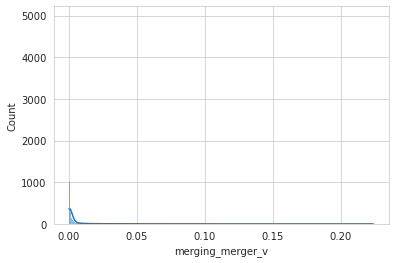

In [16]:
import seaborn as sns
sns.histplot(100*cmb.merging_merger_v, kde=True)
# sns.histplot(100*cmb.merging_none_v, kde=True)
# sns.histplot(100*cmb.merging_minor_disturbance_v, kde=True)
# sns.histplot(100*cmb.merging_major_disturbance_v, kde=True)
plt.show()

/tmp/ipykernel_35037/1739932574.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  return plt.plot(x,y,'g',linewidth=2, label=label, c=color)
/tmp/ipykernel_35037/1739932574.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  return plt.plot(x,y,'g',linewidth=2, label=label, c=color)
/tmp/ipykernel_35037/1739932574.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  return plt.plot(x,y,'g',linewidth=2, label=label, c=color)


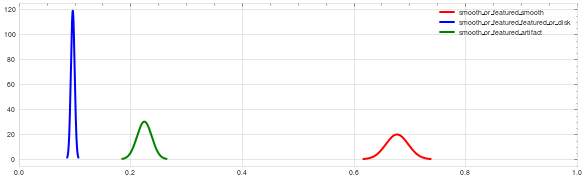

In [12]:
plt.figure(figsize=(10,3))
with plt.style.context(['science','nature']):
    idx = 134
    for i in range(len(label)):
        plot_posterior(merger.loc[idx, label[i]], 100*merger.loc[idx, label[i]+"_v"], label[i], color=color[i])
    plt.legend()
    plt.xlim((0, 1))
    # plt.ylim((0, 40))
    plt.show()

In [ ]:
mu,sigma=df.loc[0, "smooth_or_featured_smooth"], 100*df.loc[0, "smooth_or_featured_smooth_v"] #mu:期望;sigma:标准差
x= np.arange(mu - 3 * sigma, mu + 3 * sigma, 0.000001) #生成数据，步长越小，曲线越平滑
y=normpdf(x, mu, sigma)
plt.plot(x,y,'g',linewidth=2)
plt.grid()
plt.xlim((0, 1))
plt.show()
df.head()